# Twitter analysis 

<center><img src="https://techcrunch.com/wp-content/uploads/2017/12/gettyimages-876768474.jpg?w=730&crop=1"></center>

Analyze the sentiment of tweets on some query search, your model should learn from [this dataset](https://www.kaggle.com/kazanova/sentiment140)

## Install What we need to Scrap twittes:

In [ ]:
!pip install tweepy

In [ ]:
!pip install twitterscraper

# Now time to collect some tweets based on the given query

for this task you can use multiple libraries, one of the very best ones is [twitterscraper by taspinar](https://github.com/taspinar/twitterscraper).

### We will use both twitterscraper and tweepy to scra[p] our query ^_^

In [5]:
import tweepy
import re

from tweepy import OAuthHandler

consumer_api_key = 'Enter your Token'
consumer_api_secret = 'Enter your Token'
access_token = 'Enter your Token'
access_token_secret = 'Enter your Token'


In [6]:
authorizer = OAuthHandler(consumer_api_key, consumer_api_secret)
authorizer.set_access_token(access_token, access_token_secret)

# Scraping Tweets
We have successfully connected to the Twitter API. The next step is to fetch tweets.

## Putting the query you want to scrap on:

In [7]:
search_query = "virus"

In [8]:
api = tweepy.API(authorizer ,timeout=15)
all_tweets = []

for tweet_object in tweepy.Cursor(api.search,q=search_query+" -filter:retweets",lang='en',result_type='recent').items(1000):
    all_tweets.append(tweet_object.text)

In [103]:
all_tweets[:5]

['Vaccinate your children, it will not cost you as much as their death or disability cost if they ever get the infect… https://t.co/schUysDYZQ',
 "How best should we name this disease? It's high time for humanity to be sober, not just somber! https://t.co/FBl5EwD32u",
 '@FedRegister  There may be a Federal Budget re-adjustment to assure funding for the C- Virus and research toward a… https://t.co/n6wpq1R5Sl',
 '@rapgurls @Adaora_ble @BootieGoonie @OspreyLively @abueakei @SelinaxMarie I know exactly that’s my point, same with… https://t.co/EIDCeG4sAX',
 '@Awithonelison @stevenroy02 @Lex55747486 @AmerAcadPeds Doctors office and hospitals do not allow visitors who have… https://t.co/YcBOqbNluN']

# Start by building sentiment analysis classifier

In [10]:
!pip install nltk

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [11]:
# Importing required modules
import pandas as pd          
import numpy as np   
import re  
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
nltk.download('stopwords')  
from nltk.corpus import stopwords 
import pickle
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Setrow\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Reading Dataset

In [12]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

In [13]:
tweets = pd.read_csv("training.1600000.processed.noemoticon.csv",encoding = DATASET_ENCODING,names=DATASET_COLUMNS)

### Explore the Data before Preprocessing

In [104]:
tweets.head(5)

,target,ids,date,flag,user,text
0,0.0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,0.0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,0.0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,0.0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,0.0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see


In [15]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
target    1600000 non-null int64
ids       1600000 non-null int64
date      1600000 non-null object
flag      1600000 non-null object
user      1600000 non-null object
text      1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [16]:
tweets.shape

(1600000, 6)

### Rename Columns

In [17]:
%matplotlib inline

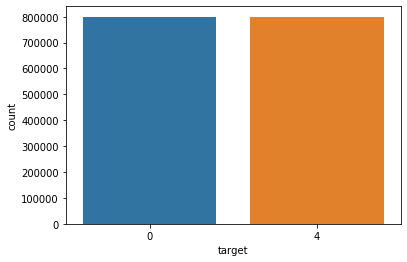

In [18]:
import seaborn as sns
sns.countplot(x='target', data=tweets)

# Data Preprocessing

### Converting the 4 in target to 1 and keep 0 as it is for predictions mesurment

In [19]:
tweets['target']=tweets['target'].apply(lambda x: x/4)

### Our dataset contains many special characters and empty spaces. You need to remove them in order to have a clean dataset, and normalized dataset

In [20]:
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [21]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [22]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [23]:
tweets.text = tweets.text.apply(lambda x: preprocess(x))

### Spliting and Train data

In [24]:
df_train, df_test = train_test_split(tweets, test_size=1-0.8, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Initalize our Bag of words function - BOW and Vectorize

In [25]:
def feature_extraction(data, method = "tfidf"):
    #arguments: data = all the tweets in the form of array, method = type of feature extracter
    #methods of feature extractions: "tfidf" and "doc2vec"
    if method == "tfidf":
        from sklearn.feature_extraction.text import TfidfVectorizer
        tfv=TfidfVectorizer(sublinear_tf=True, stop_words = "english") # we need to give proper stopwords list for better performance
        features=tfv.fit_transform(data)
    elif method == "doc2vec":
        None
    else:
        return "Incorrect inputs"
    return features

### Initalize Fuction of classifaction and prediction

In [26]:
def train_classifier(features, label, classifier = "logistic_regression"):
    
    #arguments: features = output of feature_extraction(...), label = labels in array form, classifier = type of classifier 
    from sklearn.metrics import roc_auc_score # we will use auc as the evaluation metric
    if classifier == "logistic_regression": # auc (train data): 0.8780618441250002
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(C=1.)
    elif classifier == "naive_bayes": # auc (train data): 0.8767891829687501
        from sklearn.naive_bayes import MultinomialNB
        model = MultinomialNB()
    elif classifier == "svm": # can't use sklearn svm, as way too much of data so way to slow. have to use tensorflow for svm
        from sklearn.svm import SVC
        model = SVC()
    else:
        print("Incorrect selection of classifier")
    #fit model to data
    model.fit(features, label)
    #make prediction on the same (train) data
    probability_to_be_positive = model.predict_proba(features)[:,1]
    #chcek AUC(Area Undet the Roc Curve) to see how well the score discriminates between negative and positive
    print ("auc (train data):" , roc_auc_score(label, probability_to_be_positive))
    #print top 10 scores as a sanity check
    print ("top 10 scores: ", probability_to_be_positive[:10])

### Divide to feature and goal -> feature is the text goal is the target

In [27]:
x = tweets.iloc[:, 5].values  #text
y = tweets.iloc[:, 0].values  #target

In [28]:
x

array(['awww bummer shoulda got david carr third day',
       'upset update facebook texting might cry result school today also blah',
       'dived many times ball managed save 50 rest go bounds', ...,
       'ready mojo makeover ask details',
       'happy 38th birthday boo alll time tupac amaru shakur',
       'happy charitytuesday thenspcc sparkscharity speakinguph4h'],
      dtype=object)

In [29]:
y

array([0., 0., 0., ..., 1., 1., 1.])

### Applay Logistic Regression with CountVectorizer

In [30]:
#give them max feature 5000 or 4000
cv = CountVectorizer(stop_words='english', binary=False, ngram_range=(1,3))
x_cv = cv.fit_transform(x)
x_train_cv, x_test_cv, y_train_cv, y_test_cv = train_test_split(x_cv, y, test_size=0.2, random_state=0)
from sklearn.linear_model import LogisticRegression
log_cv = LogisticRegression() 
log_cv.fit(x_train_cv,y_train_cv)

F:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
x_cv

<1600000x10567847 sparse matrix of type '<class 'numpy.int64'>'
	with 25071268 stored elements in Compressed Sparse Row format>

In [32]:
from sklearn.metrics import confusion_matrix
y_pred_cv = log_cv.predict(x_test_cv)
print(confusion_matrix(y_test_cv,y_pred_cv))
from sklearn.metrics import classification_report
print(classification_report(y_test_cv,y_pred_cv))

[[121375  38440]
 [ 30637 129548]]
              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78    159815
         1.0       0.77      0.81      0.79    160185

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



In [33]:
x_test_cv

<320000x10567847 sparse matrix of type '<class 'numpy.int64'>'
	with 5013879 stored elements in Compressed Sparse Row format>

### Apply Logistic Regression With tf-idf

In [34]:
tv = TfidfVectorizer(stop_words='english', binary=False, ngram_range=(1,3))
x_tv = tv.fit_transform(x)
x_train_tv, x_test_tv, y_train_tv, y_test_tv = train_test_split(x_tv, y, test_size=0.2, random_state=0)

In [35]:
log_tv = LogisticRegression() 
log_tv.fit(x_train_tv,y_train_tv)

F:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
y_pred_tv = log_tv.predict(x_test_tv)
print(confusion_matrix(y_test_tv,y_pred_tv))
print(classification_report(y_test_tv,y_pred_tv))

[[120400  39415]
 [ 30046 130139]]
              precision    recall  f1-score   support

         0.0       0.80      0.75      0.78    159815
         1.0       0.77      0.81      0.79    160185

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



# -----------------------------------------------------------------

# Now apply the model we have trained on the scraped data

## And Predictiing our Scraped Dataset and we will use another way to clean the scaraped dataset:

### convert List of Scraped Tweets to Datafarme

In [37]:
all_tweets_df = pd.DataFrame({'text':all_tweets})

### Applay our Model steps on Scraped data

In [39]:
all_tweets_df.text = all_tweets_df.text.apply(lambda x: preprocess(x))

In [106]:
all_tweets_df[:5]

,text
0,vaccinate children cost much death disability ...
1,best name disease high time humanity sober somber
2,may federal budget adjustment assure funding c...
3,adaora ble bootiegoonie ospreylively abueakei ...
4,stevenroy02 lex55747486 ameracadpeds doctors o...


In [41]:
xx = all_tweets_df.iloc[:, 0].values  #text

In [107]:
xx[:5]

array(['vaccinate children cost much death disability cost ever get infect',
       'best name disease high time humanity sober somber',
       'may federal budget adjustment assure funding c virus research toward',
       'adaora ble bootiegoonie ospreylively abueakei selinaxmarie know exactly point',
       'stevenroy02 lex55747486 ameracadpeds doctors office hospitals allow visitors'],
      dtype=object)

### IN CEll 30 we used Counter Vectorizer and In Cell 34 we Used tf-idf Vectorizer 
### so we will pick one of them and transorm our array target of scarped texts 
### note use transform only dont fit to keep the number of features the same as the datafarm of the kaggel dataset you just
### traind your model on!!!

In [119]:
#Using one of the vectorizers:
#x_cv = cv.transform(xx)
x_cv = tv.transform(xx)

In [51]:
x_cv

<1000x10567847 sparse matrix of type '<class 'numpy.float64'>'
	with 9552 stored elements in Compressed Sparse Row format>

## Predicit the Scraped Vectorized Text with Our trianed  Model:

In [57]:
y_pred_tv = log_tv.predict(x_cv)

### In case you want to see the tweet and its corsponding prediction of Sentiment:

In [146]:
case = [x[:5],y_pred_tv[:5]]
type(case)

list

In [147]:
for tweet,sentiment in zip(case[0], case[1]):
    print(tweet ,":", sentiment)

awww bummer shoulda got david carr third day : 0.0
upset update facebook texting might cry result school today also blah : 1.0
dived many times ball managed save 50 rest go bounds : 0.0
whole body feels itchy like fire : 1.0
behaving mad see : 0.0


### NOTE: you dont need to get coffient matrix or classifactaion matrix because we dont have true y means we dnt have the true
### predicted column for the scaped data not like the traind data of kaggel.

# ------------------------------------------------------------------------------------------------

# Let's make some good looking charts 

use your favorite plotting library to plot the sentiment aggregation of the tweets you have gathered.

### Here is sample of our prediction

In [116]:
y_pred_tv[:5]

array([0., 1., 0., 1., 0.])

### Split the positive Sentiemnets and the Nigative one to make ploting easy

In [109]:
positive_sentiment = np.count_nonzero(y_pred_tv==1.0)
nigative_sentiment = np.count_nonzero(y_pred_tv==0.0)

In [110]:
positive_sentiment

215

In [111]:
nigative_sentiment

785

## PLOTING TIME:

Text(0.5, 0.98, 'Categorical Plotting For "virus" Twitte Sentiment Analysis')

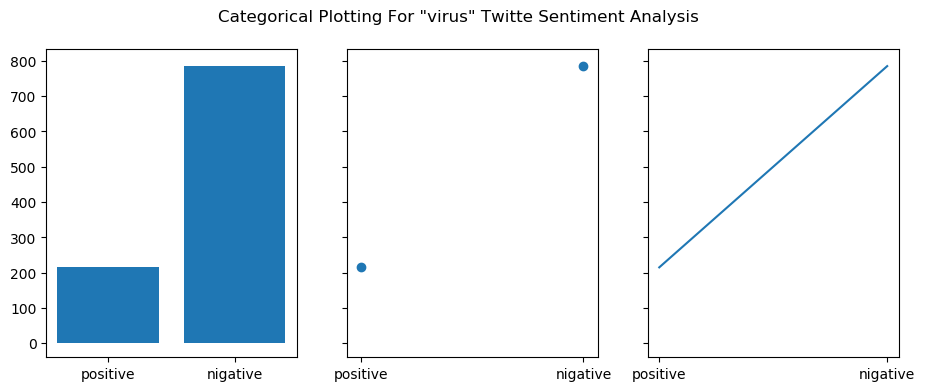

In [115]:
import matplotlib.pyplot as plt

data = {'positive': positive_sentiment, 'nigative': nigative_sentiment}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 3, figsize=(11, 4), sharey=True)
axs[0].bar(names, values)
axs[1].scatter(names, values)
axs[2].plot(names, values)
fig.suptitle(f'Categorical Plotting For "{search_query}" Twittes Sentiment Analysis')

# Good job ! 

<center><img src="https://media.giphy.com/media/YRuFixSNWFVcXaxpmX/giphy.gif"></center>

# Now publish the notebook and show the world your work !